In [23]:
%matplotlib notebook

import time
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import tqdm.notebook as tqdm

In [2]:
def octilinearity_constraint(G, weight):
    nodes = G.nodes(data=True)
    for a, b in G.edges():
        # Calculate distance vector between nodes
        diff = nodes[a]['pos'] - nodes[b]['pos']
        # Calculate edge angle
        phi = np.mod(np.arctan2(diff[1], diff[0]), 2*np.pi)
        # Calculate restoring moment
        moment = weight * (round(4 * phi / np.pi) - 4 * phi / np.pi)
        # Assign forces to nodes
        nodes[a]['force'] += np.array([-moment * np.sin(phi), moment * np.cos(phi)])
        nodes[b]['force'] += np.array([moment * np.sin(phi), -moment * np.cos(phi)])


def distance_constraint(G, k=10.0, x0=10.0):
    nodes = G.nodes(data=True)
    for a, b in G.edges():
        # Calculate distance vector between nodes
        diff = nodes[a]['pos'] - nodes[b]['pos']

        # Calculate edge angle
        phi = np.arctan2(diff[1], diff[0])
        
        # Calculate node distance (manhattan norm)
        x = np.linalg.norm(diff, ord=1)
        #print(x)
        
        # Calculate spring force based on hookes law:
        f = 0
        if x < x0:
            f = -k * (x - x0)
        elif x > np.sqrt(2) * x0:
            f = -k * (x - x0 * (np.sqrt(2) - 1))

        fvec = np.array([f * np.cos(phi), f * np.sin(phi)])

        # Assign forces to nodes
        nodes[a]['force'] += fvec
        nodes[b]['force'] -= fvec


def location_accuracy_constraint(G, weight):
    for idx, node in G.nodes(data=True):
        # Calculate the distance between the current position of the node and its original position (euclidean)
        r = node['origin'] - node['pos']
        # Apply a force that pulls the node towards its original position
        node['force'] += r * weight


def get_positions(graph, keyword='pos'):
    pos = {}
    for idx, node in graph.nodes.items():
        pos[idx] = node[keyword]
    return pos


def generate_graph(N=10):
    G = nx.Graph()

    for i in range(N-1):
        G.add_edge(i, i+1)
        
    phi = 0
    for idx, node in G.nodes(data=True):
        node['force'] = np.zeros(2)
        if idx == 0:
            node['pos'] = 25 + 50 * np.random.rand(2)
        else:
            r = 10 + np.random.rand(1)[0] * 20
            phi += (0.5 - np.random.rand(1)[0]) * 2 * np.pi
            node['pos'] = G.nodes(data=True)[idx-1]['pos'] + np.array([r*np.cos(phi), r*np.sin(phi)])
        # Make a copy of the original positions so that we can use them later on
        node['origin'] = node['pos'].copy()

    return G


def plot_graph(fig, ax, graph):
    nx.draw(graph, pos=get_positions(graph), ax=ax, node_size=10)
    fig.canvas.draw()


def apply_forces(G, alpha):
    for _, node in G.nodes(data=True):
        node['pos'] += alpha * node['force']
        node['force'] = np.zeros(2)

<IPython.core.display.Javascript object>


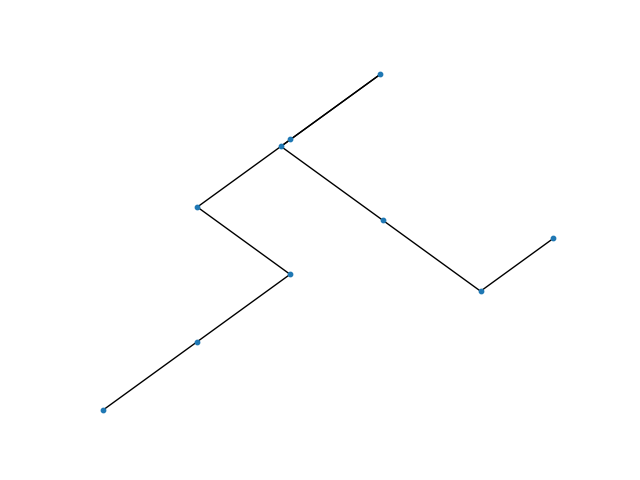

  0%|          | 0/100 [00:00<?, ?it/s]

In [37]:
# "Learning Rate"
alpha = 0.01

# Weights to tune the importance of visual aspects
octilinearity_weight = 100.0
distance_weight = 10.0
location_accuracy_weight = 10.0

# Distance between stations
station_distance = 10.0

# Generate a random new graph
G = generate_graph()


fig, ax = plt.subplots(1,1)

iterations = 100
for i in tqdm.tqdm(range(iterations)):
    do = octilinearity_weight * max(1, 1 + (i - 30)/(iterations - 30))
    octilinearity_constraint(G, do)
    dw = distance_weight * min(1, 1 - (i - 30)/(iterations - 30))
    #print(1 - (i - 30)/(iterations - 30))
    distance_constraint(G, dw, station_distance)
    #location_accuracy_constraint(G, 1 * min(1, 1 - (i - 30)/(iterations - 30)))
    apply_forces(G, alpha)

    # Plotting
    ax.clear()
    nx.draw(G, pos=get_positions(G), ax=ax, node_size=10)
    fig.canvas.draw()

    # Wait a little bit
    time.sleep(.016)


# Plotting with plotly

In [48]:
import plotly.graph_objects as go
G = nx.random_geometric_graph(20, 0.25)

In [84]:
def unravel_network(G):
    # Edges
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['pos']
        x1, y1 = G.nodes[edge[1]]['pos']
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
        
    # Nodes
    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = G.nodes[node]['pos']
        node_x.append(x)
        node_y.append(y)
        
    return edge_x, edge_y, node_x, node_y


def create_traces(edge_x, edge_y, node_x, node_y):
    # Plot Edges
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')
    
    # Plot Nodes
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            size=10,
            line_width=2))
    return edge_trace, node_trace


def update_traces(fig, edge_x, edge_y, node_x, node_y):
    with fig.batch_update():
        fig.data[0].x = edge_x
        fig.data[0].y = edge_y
        fig.data[1].x = node_x
        fig.data[1].y = node_y


def create_figure(edge_trace, node_trace):
    # Create the final plot
    fig = go.Figure(data=[edge_trace, node_trace], layout=go.Layout(showlegend=False))#,
             #layout=go.Layout(
                #showlegend=False,
                #hovermode='closest',
                #margin=dict(b=20,l=5,r=5,t=40),
                #xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                #yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
              #  )
    return fig


In [85]:
def wiggle(G, amount=.1):
    for idx, node in G.nodes(data=True):
        x, y = node['pos']
        node['pos'] = [x + amount*(0.5 - np.random.rand(1)[0]), y + amount*(0.5 - np.random.rand(1)[0])]
    return G


In [89]:
traces = unravel_network(G)
edge_trace, node_trace = create_traces([], [], [], [])
fig = create_figure(edge_trace, node_trace)
fig

In [91]:
for i in range(10):
    G = wiggle(G, amount=5)
    _, _, node_x, node_y = unravel_network(G)
    #update_traces(fig, *traces)
    #with fig.batch_update():
        #fig.data[0].x = edge_x
        #fig.data[0].y = edge_y
    fig.data[1].x = node_x
    fig.data[1].y = node_y
    time.sleep(.3)

In [56]:
data = [1,3,2,4,3,3,2,3]
fig = go.FigureWidget()
fig.add_scatter()
fig

FigureWidget({
    'data': [{'type': 'scatter', 'uid': 'd04e0ad8-bcf6-4152-8623-7d0f2bb6c165'}], 'layout': {'t…

In [57]:
for i in range(len(data)):
    time.sleep(0.3)
    with fig.batch_update():
        fig.data[0].y = data[:i]